In [35]:
import os
from functools import partial

from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp


from flax import linen as nn
from flax.training.train_state import TrainState
import optax


In [26]:
target_img = plt.imread("../pbRender/renderedImages/image576.jpg")/255.

In [28]:
plt.subplot(121); plt.imshow(target_img)
plt.subplot(122); plt.imshow(target_img[:, ::-1])

In [29]:
class CPPN(nn.Module):
    hidden_dims: list
    @nn.compact
    def __call__(self, x):
        for dim in self.hidden_dims:
            x = nn.Dense(dim)(x)
            x = nn.relu(x)
        x = nn.Dense(3)(x)
        return x

    def generate_image(self, params):
        x = y = jnp.linspace(-1, 1, 256)
        x, y = jnp.meshgrid(x, y, indexing='ij')
        d = jnp.sqrt(x**2 + y**2)
        xyd = jnp.stack([x, y, d], axis=-1)
        rgb = jax.vmap(jax.vmap(partial(self.apply, params)))(xyd)
        rgb = jax.nn.sigmoid(rgb)
        return rgb


In [50]:
# cppn = CPPN([50, 50, 50])

# rng = jax.random.PRNGKey(0)
# x = jnp.zeros((3,))
# params = cppn.init(rng, x)

# tx = optax.adam(learning_rate=3e-4)
# state = TrainState.create(apply_fn=cppn.apply, params=params, tx=tx)

# def loss_fn(params, target_img):
#     img = cppn.generate_image(params)
#     return jnp.mean((img - target_img)**2)

# def train_step(state, target_img):
#     img = cppn.generate_image(state.params)
#     loss, grad = jax.value_and_grad(loss_fn)(state.params, target_img)
#     state = state.apply_gradients(grads=grad)
#     return state, loss

# losses = []
for t in tqdm(range(1000)):
    state, loss = train_step(state, target_img)
    losses.append(loss)

plt.plot(losses)


  0%|          | 0/1000 [00:00<?, ?it/s]

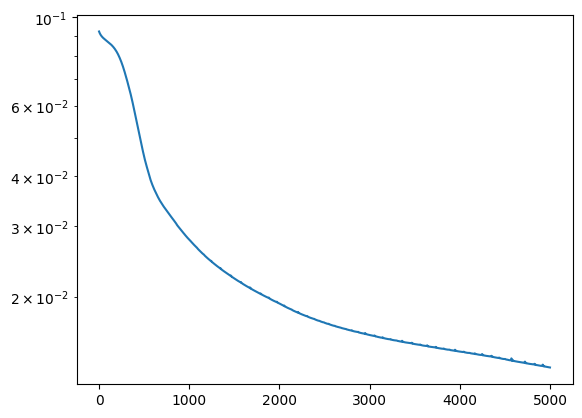

In [52]:
plt.plot(losses)
plt.yscale('log')

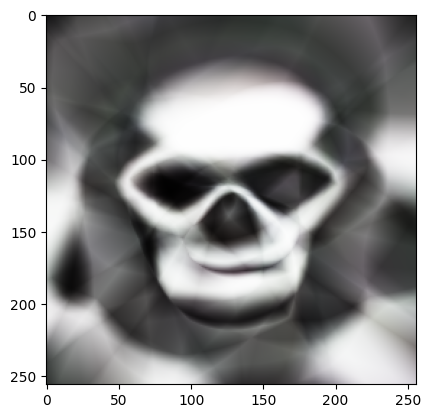

In [54]:
plt.imshow(cppn.generate_image(state.params))

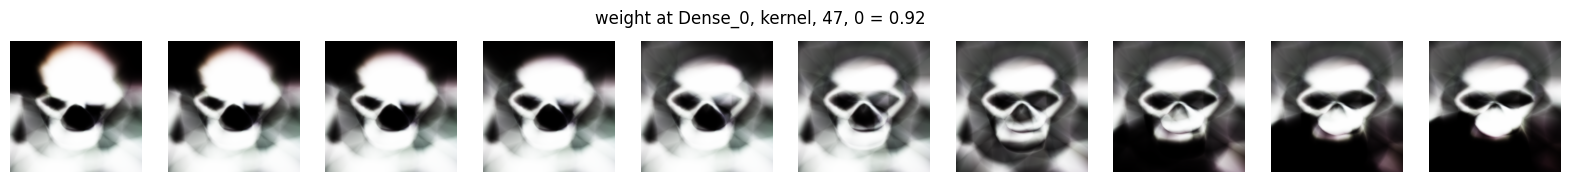

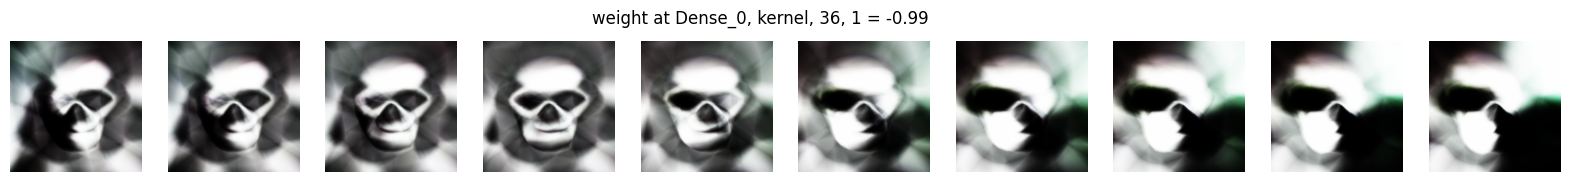

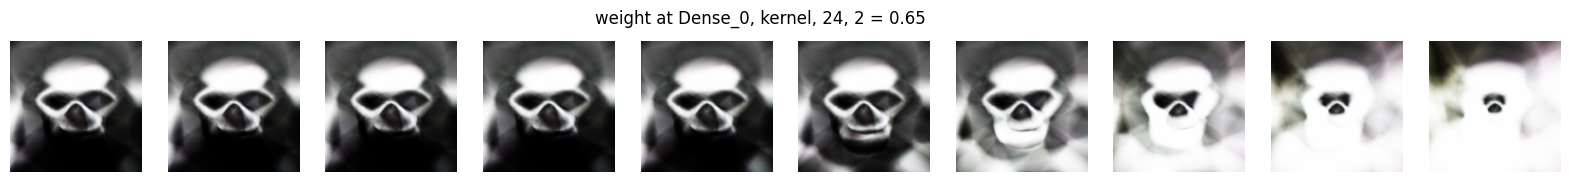

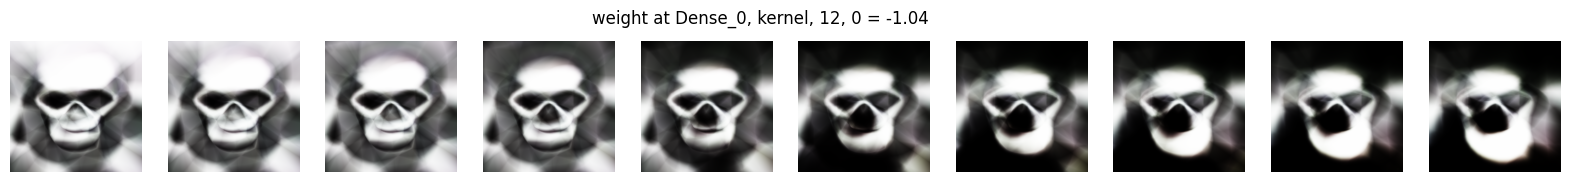

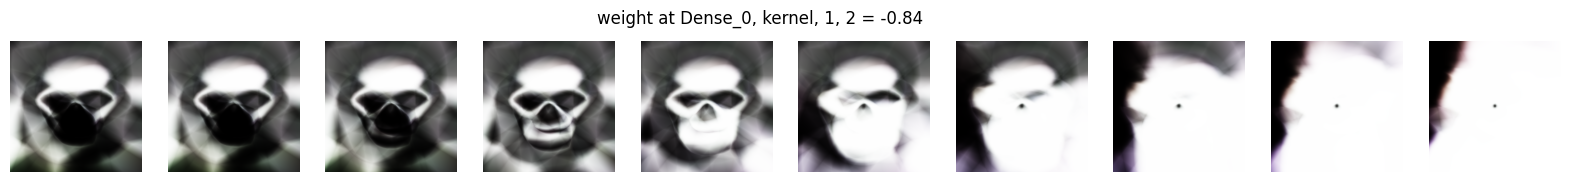

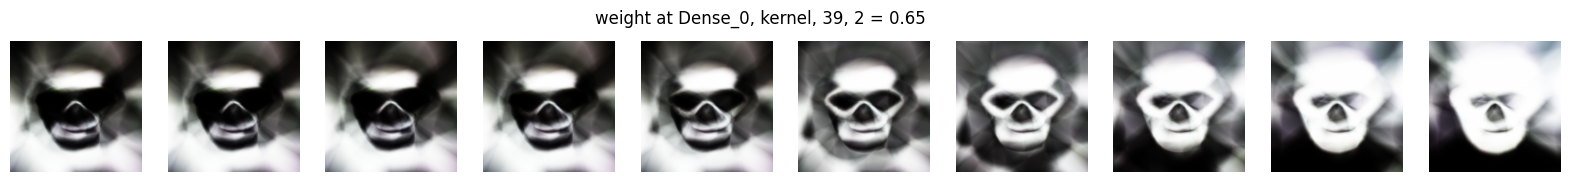

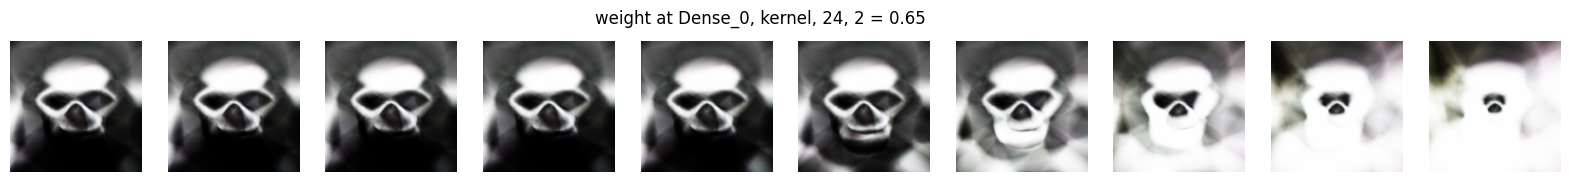

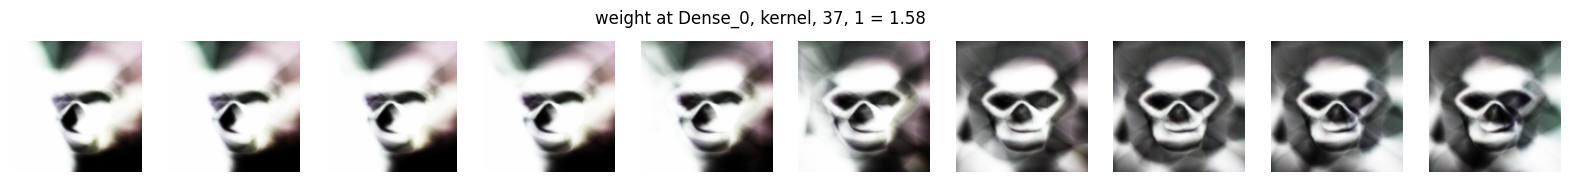

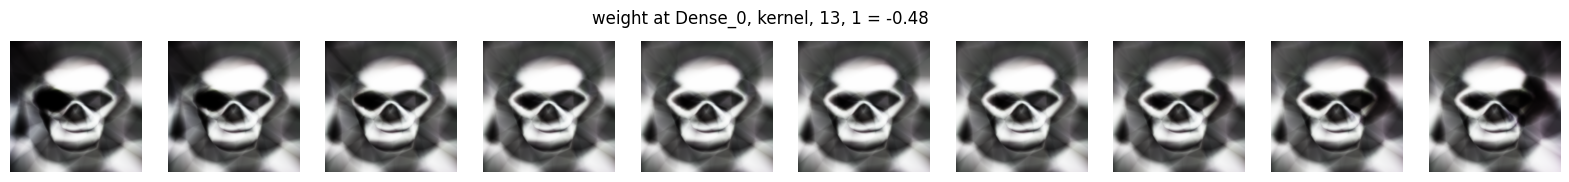

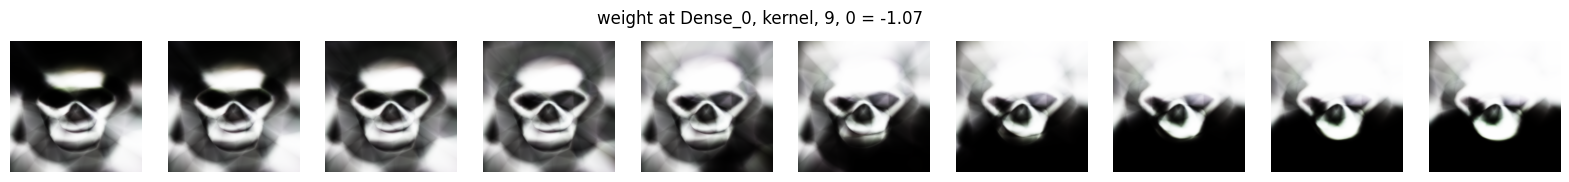

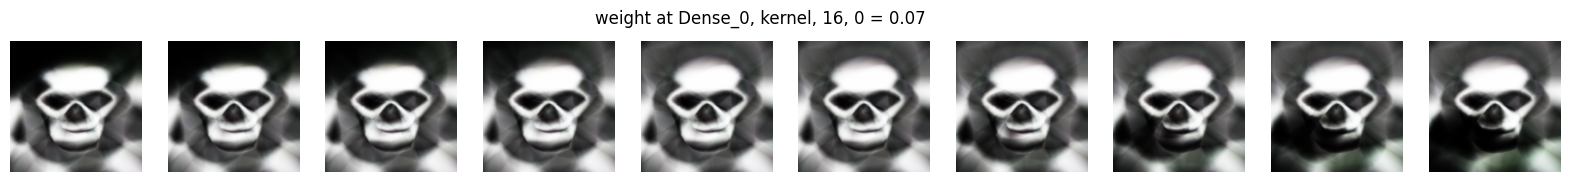

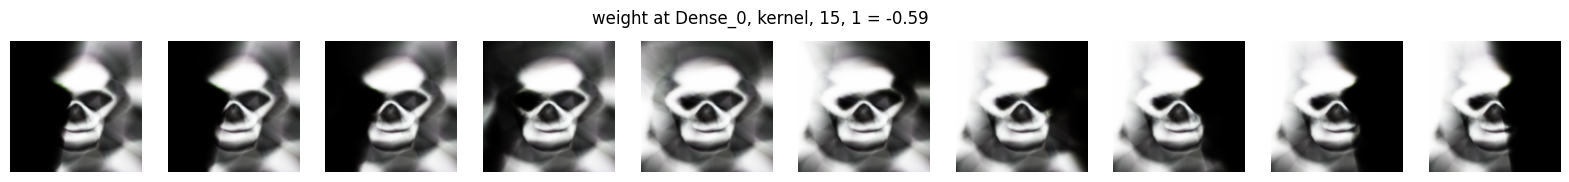

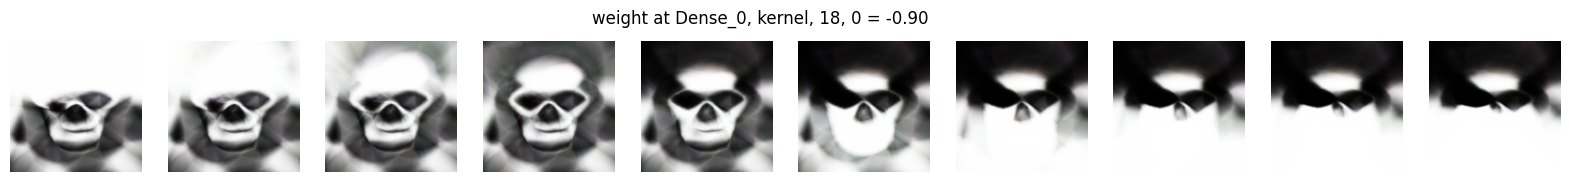

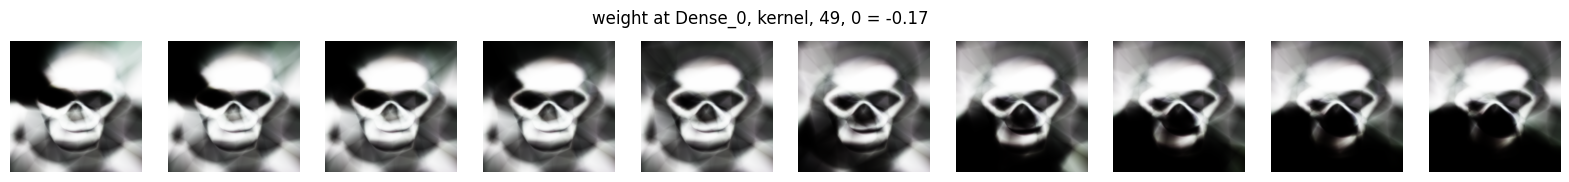

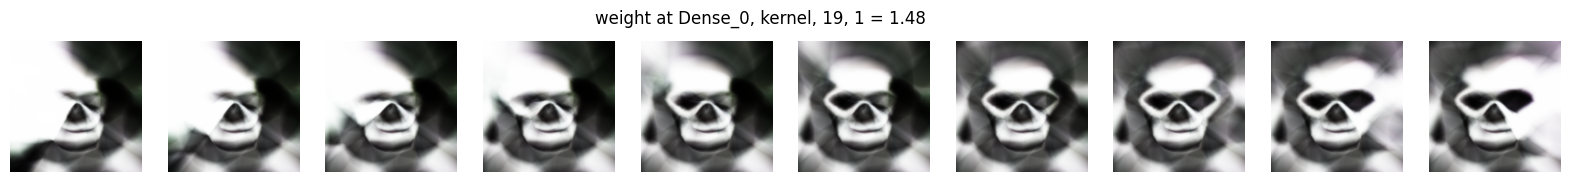

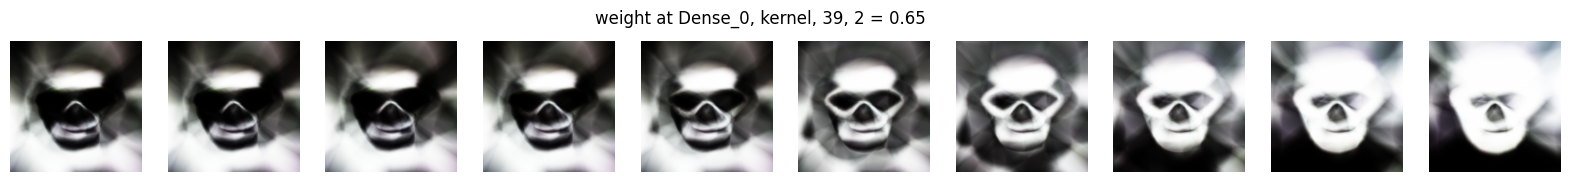

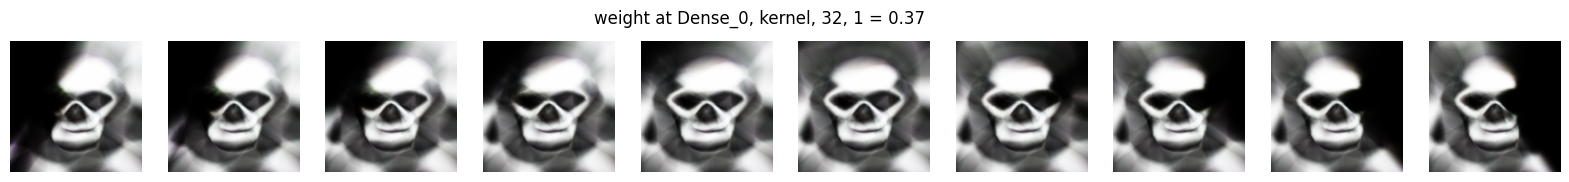

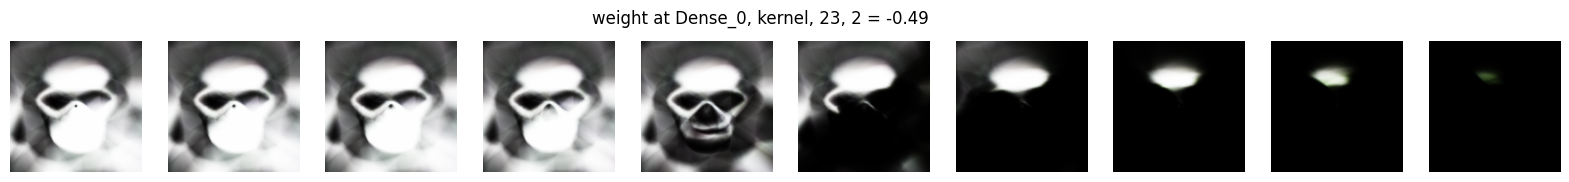

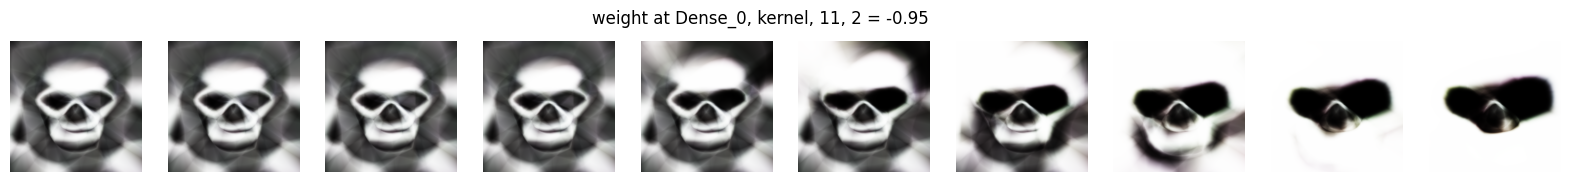

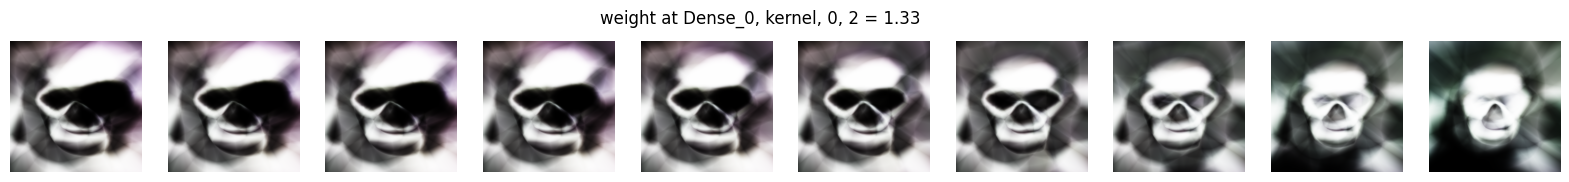

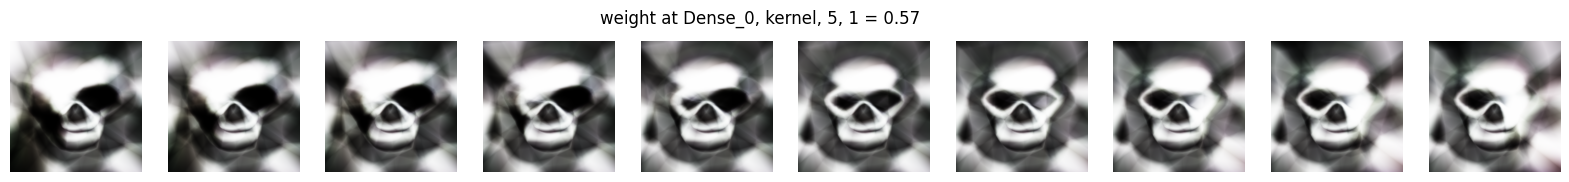

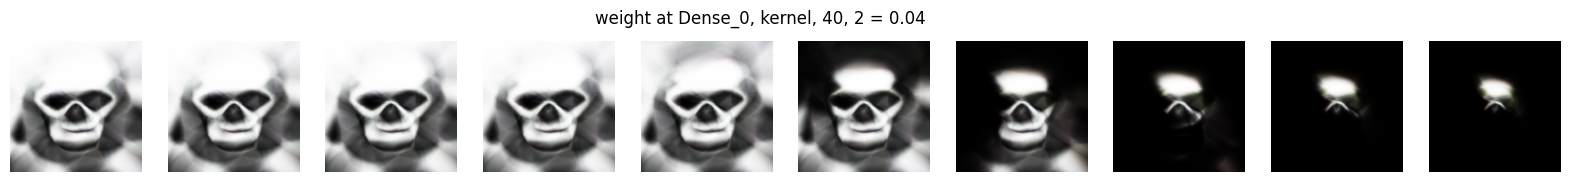

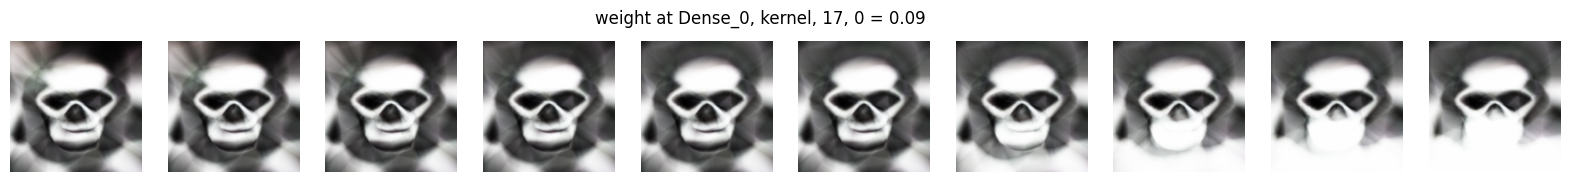

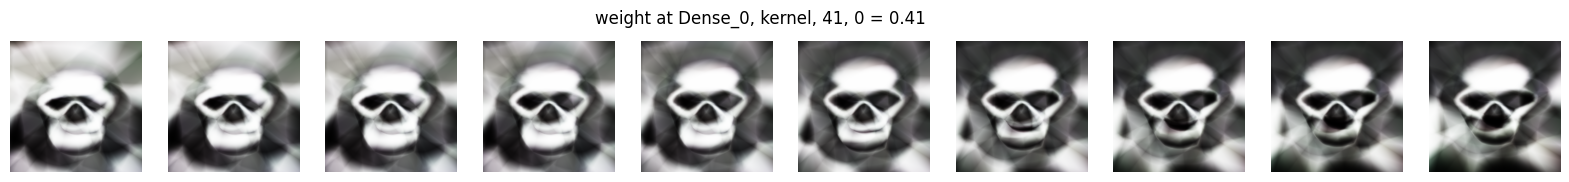

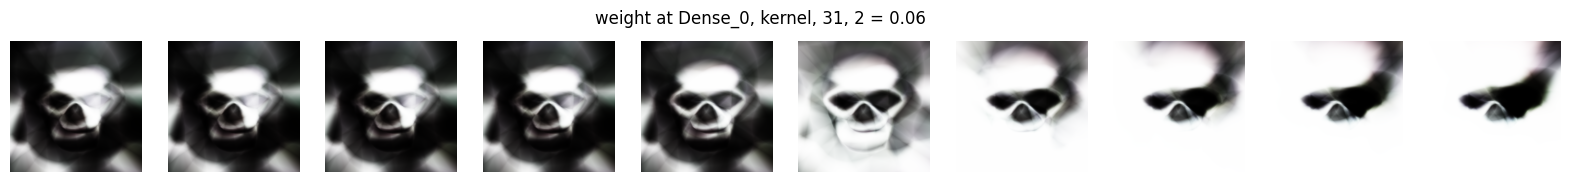

In [110]:
params = state.params
np.random.seed(0)

layer_id = ('Dense_0', 'kernel')

for _ in range(30):
    shape = params['params'][layer_id[0]][layer_id[1]].shape
    wi = np.random.randint(shape[0])
    wj = np.random.randint(shape[1])
    plt.figure(figsize=(20, 2))
    for i in jnp.arange(10):
        val = jnp.linspace(-3, 3, 10)[i]
        params_p = jax.tree.map(lambda x: x.clone(), params)
        params_p['params'][layer_id[0]][layer_id[1]] = params_p['params'][layer_id[0]][layer_id[1]].at[wi, wj].set(val)
        img = cppn.generate_image(params_p)
        plt.subplot(1, 10, i.item()+1); plt.imshow(img); plt.axis('off')

    ori_val = params['params'][layer_id[0]][layer_id[1]][wi, wj].item()
    plt.suptitle(f"weight at {layer_id[0]}, {layer_id[1]}, {wj}, {wi} = {ori_val:.2f}")
    plt.show()